# Choosing the best ramp profile

In [1]:
from pathlib import Path
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import pandas as pd

import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

import nemplot

from IPython.display import display, HTML

In [2]:
DICT_LINES = 19

In [3]:
os.chdir(str(Path.home() / "code" / "TeslaMax"))

In [4]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

In [5]:
def filter_table_from_column(table,column,value):
    """
    Return a view into the 'table' DataFrame, selecting only the rows where
    'column' equals 'value'
    """
    
    return table[table[column] == value]

## Results from AMR simulations

In [6]:
# Fixed parameters

PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 25e-3,
    "H[m]": 22e-3,
    "N_r[]": 8,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

In [7]:
OPERATIONAL_PARAMETERS = {
    "Q_c[W]": 100
}

From our AMR simualtions with the above parameters, for a high field of 1.3 T:

In [8]:
display(HTML("<table><tr><td><img src='figures/Qc_FM_ramp_f_1_Phi_40_35K_1.3T.png' width=500></td><td><img src='figures/COP_FM_ramp_f_1_Phi_40_35K_1.3T.png' width=500></td></tr></table>"))

,


Notice that, to maximize COP, it is interesting to work with a blow fraction between 70% and 80%, for a magnetization fraction between 30 and 35%; this results in cooling capacities between 140 and 150 W.

But this only applies for 1.3 T. For more compact magnets, we have to look into how is the performance for smaller magnetic fields:

In [9]:
display(HTML("<table><tr><td><img src='figures/Qc_ramp_map_f_1_Phi_40_FB_70_35K.png' width=500></td><td><img src='figures/COP_ramp_map_f_1_Phi_40_FB_70_35K_Valv_4W.png' width=500></td></tr></table>"))

,


In [10]:
display(HTML("<table><tr><td><img src='figures/Qc_ramp_map_f_1_Phi_40_FB_80_35K.png' width=500></td><td><img src='figures/COP_ramp_map_f_1_Phi_40_FB_80_35K_Valv_4W.png' width=500></td></tr></table>"))

,


For this range, a profile of 1.25 T for 40% of the cycle should yield cooling capacities of 140 W, with a COP of 1.7.

## Maps for R_s

From the above maps, then we have to find a geometry that is capable of generating these magnetic profiles. However, a primary concern is the size of the required magnet.

These maps shows the minimum value of $R\ped{s}$ that will yield a cost function less than unity, for a given pair of (magnetization fraction, maximum field) (the same independent variables in the above AMR maps). Some values of $R\ped{o}$ are tested, and other parameters are fixed (check the files `map_Rs_Ro_XX.txt` for more information).

In [11]:
def get_Rs_map_vectors(R_o):
    """
    Return (F_M, B_max, R_s) as arrays to be plotted with contourf,
    from the results file for 'R_o' (in mm)
    """
    
    filename = "map_Rs_Ro_%d.txt" %(R_o,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with open(file_path) as f:
        flines = f.readlines()
        
    params = eval("".join(flines[0:DICT_LINES]))
    
    n = params["n_II"] + params["n_IV"]
    
    # parse the results file
    column_names = ["B_max[T]",
               "F_M[%]",
               "R_s[mm]",
               "K[]"] + (
    ["alpha_II_%d" %(i+1) for i in range(0,params["n_II"])] + 
    ["alpha_IV_%d" %(j+1) for j in range(0,params["n_IV"])])
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=20,names=column_names,header=0)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','F_M[%]','R_s[mm]')
    
    X=mp.columns.values
    Y=mp.index.values
    R_s=mp.values
    F_M, B_max =np.meshgrid(X, Y)
    
    return (F_M,B_max,R_s)

For the inner magnet radius of 40 mm:

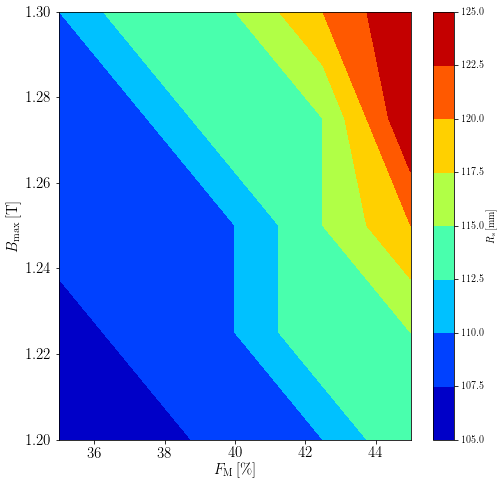

In [12]:
%matplotlib inline

fig, ax = nemplot.create_plot(xlabel=r'$F\ped{M}\,[\si{\percent}]$',
                             ylabel=r'$B\ped{max}\,[\si{\tesla}]$')

F_M, B_max, R_s = get_Rs_map_vectors(40)

R_s_contour = ax.contourf(F_M,B_max,R_s,cmap='jet')
R_s_colorbar = fig.colorbar(R_s_contour,ax=ax)
R_s_colorbar.set_label(r'$R\ped{s}\,[\si{\mm}]$')

And for 50 mm:

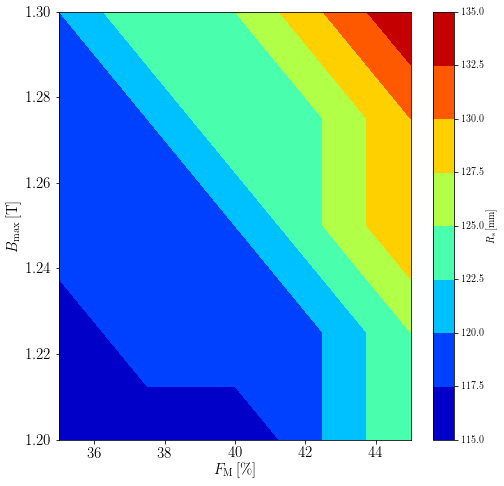

In [13]:
%matplotlib inline

fig, ax = nemplot.create_plot(xlabel=r'$F\ped{M}\,[\si{\percent}]$',
                             ylabel=r'$B\ped{max}\,[\si{\tesla}]$')

F_M, B_max, R_s = get_Rs_map_vectors(50)

R_s_contour = ax.contourf(F_M,B_max,R_s,cmap='jet')
R_s_colorbar = fig.colorbar(R_s_contour,ax=ax)
R_s_colorbar.set_label(r'$R\ped{s}\,[\si{\mm}]$')

Due to the computational cost of these simulations, the resolution for the axes are low, and hence these maps should only give loose indications of the required size of the magnet for a given profile. The actual shape of the profile should be checked with other simulations.

But from our earlier estimative, these maps indicates that a profile of 1.25 T for 40% of the cycle could be implemented with a magnet smaller than 110 mm in external diamater - and we can further optimize from there.

## Compact AMRs

By keeping other parameters constant, and keeping the magnetization fraction at 35%, we can generate a map of AMR performance as a function of regenerator height:

In [11]:
display(HTML("<table><tr><td><img src='figures/Qc_H_reg.png' width=500></td><td><img src='figures/COP_H_reg.png' width=500></td></tr></table>"))

,


Now, based on the previous magnet and AMR maps, we select an external radius od 120 mm and internal radius of 50 mm, and we vary the air gap height, to see the ability of the TeslaMax model to generate these magnetic profiles.

In [14]:
def get_hgap_map_vectors(phi_S):
    """
    Return (h_gap, B_max, K) as arrays to be plotted with contourf
    """
    
    filename = "map_K.txt"
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with open(file_path) as f:
        flines = f.readlines()
    
    hgap_map_dict_lines = 14
    
    params = eval("".join(flines[0:hgap_map_dict_lines]))
    
    # parse the results file
    column_names = ["phi_S[deg]",
                    "h_gap[mm]",
                    "B_max[T]",
                   "K[]"]
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=hgap_map_dict_lines,names=column_names,header=0)

    map_table = filter_table_from_column(map_table,"phi_S[deg]",phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','K[]')
     
    X=mp.columns.values
    Y=mp.index.values
    K=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,K)

In [17]:
def plot_K_maps(phi_S):
    
        
    fig, ax = nemplot.create_plot(xlabel=r'$h\ped{gap}\,[\si{\mm}]$',
                             ylabel=r'$B\ped{max}\,[\si{\tesla}]$')

    h_gap, B_max, K = get_hgap_map_vectors(phi_S)
    
    h_gap_contour = ax.contourf(h_gap,B_max,K,cmap='jet')
    h_gap_colorbar = fig.colorbar(h_gap_contour,ax=ax)
    h_gap_colorbar.set_label(r'$K\,[]$')

    ax.set_xticks(np.linspace(np.min(h_gap),np.max(h_gap),11))
    
    nemplot.save_figure(fig,"map_K_hgap_phi_%d" %(phi_S))

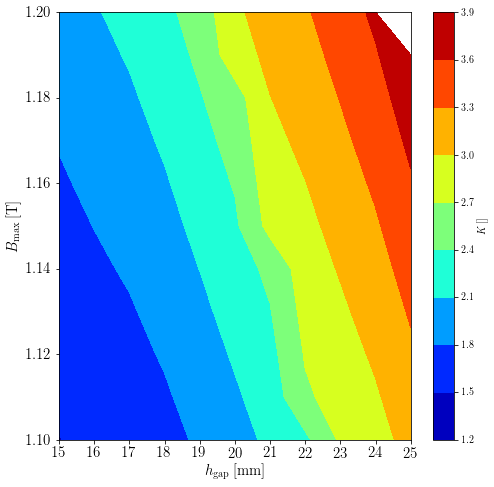

In [18]:
%matplotlib inline
plot_K_maps(35)

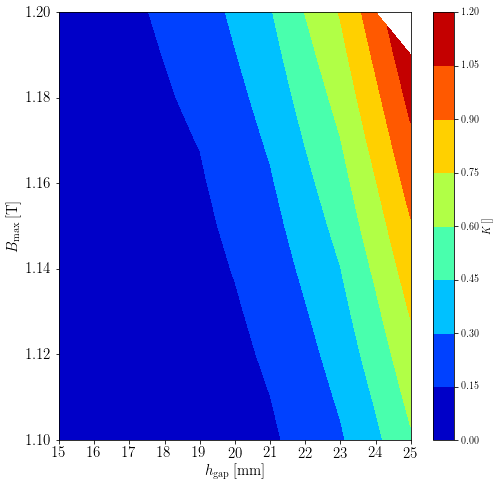

In [19]:
plot_K_maps(45)

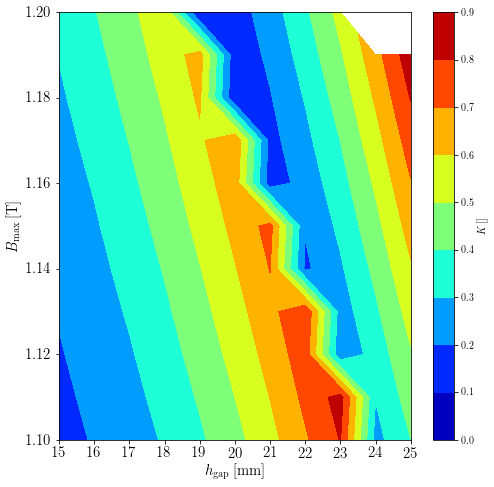

In [20]:
plot_K_maps(55)